# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/usmanrizwan/PycharmProjects/CNN/cifar-10-batches-py/'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for rg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rg,
                      num_iters=1500, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        train_val_acc = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % (train_val_acc, ))
        y_val_pred = svm.predict(X_val_feats)
        test_val_acc = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % (test_val_acc, ))
        results[(lr, rg)] = (train_val_acc, test_val_acc)
        if test_val_acc > best_val:
            best_val = test_val_acc
            best_svm = svm
        

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 89.102664
iteration 100 / 1500: loss 87.509001
iteration 200 / 1500: loss 85.957468
iteration 300 / 1500: loss 84.421173
iteration 400 / 1500: loss 82.942608
iteration 500 / 1500: loss 81.470526
iteration 600 / 1500: loss 80.039843
iteration 700 / 1500: loss 78.623478
iteration 800 / 1500: loss 77.258991
iteration 900 / 1500: loss 75.896624
iteration 1000 / 1500: loss 74.569446
iteration 1100 / 1500: loss 73.275880
iteration 1200 / 1500: loss 71.993563
iteration 1300 / 1500: loss 70.755943
iteration 1400 / 1500: loss 69.537741
training accuracy: 0.121959
validation accuracy: 0.133000
iteration 0 / 1500: loss 775.066060
iteration 100 / 1500: loss 636.149926
iteration 200 / 1500: loss 522.410062
iteration 300 / 1500: loss 429.305717
iteration 400 / 1500: loss 353.079849
iteration 500 / 1500: loss 290.684441
iteration 600 / 1500: loss 239.592921
iteration 700 / 1500: loss 197.774253
iteration 800 / 1500: loss 163.545554
iteration 900 / 1500: loss 135.505729
iterat

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.415


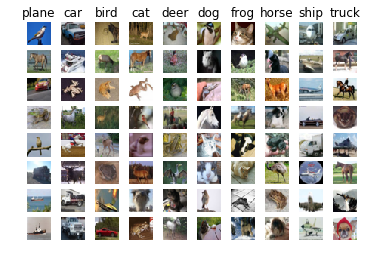

In [9]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
#         plt.figure(figsize = (5,5))
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ The misclassification do make sense, for e.g. we can see a bird against a blue sky classified as a plane, an upclose face of a cat is misclassified as a dog, am image of a plane from beneath against the blue sky is classified as a ship. In a lot os misclassification it is the background that seems to tip the balance for the algorithm in favour of a specific class.




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [10]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [60]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

hyper_params = {'hidden_size': [250, 300, 400, 500, 600], 
               'learning_rate': [1e-2, 1e-1, 1e0,], 
                'learning_rate_decay':[0.6, 0.75, 0.8, 0.9, 0.95, 0.99], 
               'reg': [1e-4, 1e-3, 1e-2]}

results = {}
best_val = -1

for hd in hyper_params['hidden_size']:
    for lr in hyper_params['learning_rate']:
        for lrd in hyper_params['learning_rate_decay']:
            for r in hyper_params['reg']:
                print(lr, lrd, r)
                net = TwoLayerNet(input_dim, hd, num_classes)
                # Train the network
                stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                            num_iters=1500, batch_size=200,
                            learning_rate=lr, learning_rate_decay=lrd,
                            reg=r, verbose=True)

                # Predict on the validation set
                val_acc = (net.predict(X_val_feats) == y_val).mean()
                print('Validation accuracy: ', val_acc)

                if val_acc > best_val:
                    best_val = val_acc
                    best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


0.01 0.6 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.302508
iteration 200 / 1500: loss 2.302453
iteration 300 / 1500: loss 2.302686
iteration 400 / 1500: loss 2.302331
iteration 500 / 1500: loss 2.302590
iteration 600 / 1500: loss 2.302576
iteration 700 / 1500: loss 2.302617
iteration 800 / 1500: loss 2.302893
iteration 900 / 1500: loss 2.302454
iteration 1000 / 1500: loss 2.302515
iteration 1100 / 1500: loss 2.302665
iteration 1200 / 1500: loss 2.302534
iteration 1300 / 1500: loss 2.302515
iteration 1400 / 1500: loss 2.302658
Validation accuracy:  0.102
0.01 0.6 0.001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.302661
iteration 200 / 1500: loss 2.302551
iteration 300 / 1500: loss 2.302670
iteration 400 / 1500: loss 2.302398
iteration 500 / 1500: loss 2.302591
iteration 600 / 1500: loss 2.302883
iteration 700 / 1500: loss 2.302515
iteration 800 / 1500: loss 2.302491
iteration 900 / 1500: loss 2.302444
iteration 1000 / 1500: loss 2.302413
ite

iteration 100 / 1500: loss 2.302412
iteration 200 / 1500: loss 2.302885
iteration 300 / 1500: loss 2.302851
iteration 400 / 1500: loss 2.302609
iteration 500 / 1500: loss 2.302586
iteration 600 / 1500: loss 2.302760
iteration 700 / 1500: loss 2.302790
iteration 800 / 1500: loss 2.302772
iteration 900 / 1500: loss 2.302298
iteration 1000 / 1500: loss 2.302071
iteration 1100 / 1500: loss 2.302356
iteration 1200 / 1500: loss 2.302132
iteration 1300 / 1500: loss 2.302394
iteration 1400 / 1500: loss 2.302077
Validation accuracy:  0.098
0.01 0.99 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.302583
iteration 200 / 1500: loss 2.302577
iteration 300 / 1500: loss 2.302033
iteration 400 / 1500: loss 2.302676
iteration 500 / 1500: loss 2.302437
iteration 600 / 1500: loss 2.303068
iteration 700 / 1500: loss 2.302359
iteration 800 / 1500: loss 2.302516
iteration 900 / 1500: loss 2.302212
iteration 1000 / 1500: loss 2.302849
iteration 1100 / 1500: loss 2.302038
iteration 1200

iteration 100 / 1500: loss 2.302156
iteration 200 / 1500: loss 2.226268
iteration 300 / 1500: loss 1.917570
iteration 400 / 1500: loss 1.639390
iteration 500 / 1500: loss 1.572821
iteration 600 / 1500: loss 1.540356
iteration 700 / 1500: loss 1.489379
iteration 800 / 1500: loss 1.334477
iteration 900 / 1500: loss 1.407775
iteration 1000 / 1500: loss 1.497746
iteration 1100 / 1500: loss 1.411466
iteration 1200 / 1500: loss 1.491346
iteration 1300 / 1500: loss 1.197473
iteration 1400 / 1500: loss 1.369009
Validation accuracy:  0.525
0.1 0.9 0.01
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 2.301825
iteration 200 / 1500: loss 2.260576
iteration 300 / 1500: loss 1.992022
iteration 400 / 1500: loss 1.799302
iteration 500 / 1500: loss 1.709529
iteration 600 / 1500: loss 1.702836
iteration 700 / 1500: loss 1.556116
iteration 800 / 1500: loss 1.660571
iteration 900 / 1500: loss 1.597128
iteration 1000 / 1500: loss 1.592268
iteration 1100 / 1500: loss 1.645481
iteration 1200 / 1

iteration 100 / 1500: loss 1.600398
iteration 200 / 1500: loss 1.457720
iteration 300 / 1500: loss 1.194831
iteration 400 / 1500: loss 1.249201
iteration 500 / 1500: loss 1.148817
iteration 600 / 1500: loss 1.204128
iteration 700 / 1500: loss 1.094271
iteration 800 / 1500: loss 1.034635
iteration 900 / 1500: loss 0.953381
iteration 1000 / 1500: loss 0.942804
iteration 1100 / 1500: loss 0.874864
iteration 1200 / 1500: loss 1.067992
iteration 1300 / 1500: loss 0.842268
iteration 1400 / 1500: loss 0.883315
Validation accuracy:  0.593
1.0 0.8 0.001
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.518824
iteration 200 / 1500: loss 1.299137
iteration 300 / 1500: loss 1.261776
iteration 400 / 1500: loss 1.396513
iteration 500 / 1500: loss 1.452247
iteration 600 / 1500: loss 1.150202
iteration 700 / 1500: loss 1.283816
iteration 800 / 1500: loss 1.300194
iteration 900 / 1500: loss 1.219837
iteration 1000 / 1500: loss 1.147394
iteration 1100 / 1500: loss 1.198005
iteration 1200 / 

iteration 100 / 1500: loss 2.302524
iteration 200 / 1500: loss 2.302595
iteration 300 / 1500: loss 2.302808
iteration 400 / 1500: loss 2.302752
iteration 500 / 1500: loss 2.302560
iteration 600 / 1500: loss 2.302734
iteration 700 / 1500: loss 2.302620
iteration 800 / 1500: loss 2.302787
iteration 900 / 1500: loss 2.302684
iteration 1000 / 1500: loss 2.302610
iteration 1100 / 1500: loss 2.302462
iteration 1200 / 1500: loss 2.302521
iteration 1300 / 1500: loss 2.302509
iteration 1400 / 1500: loss 2.302120
Validation accuracy:  0.078
0.01 0.75 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.302551
iteration 200 / 1500: loss 2.302441
iteration 300 / 1500: loss 2.302649
iteration 400 / 1500: loss 2.302548
iteration 500 / 1500: loss 2.302697
iteration 600 / 1500: loss 2.302281
iteration 700 / 1500: loss 2.302386
iteration 800 / 1500: loss 2.302698
iteration 900 / 1500: loss 2.302660
iteration 1000 / 1500: loss 2.302381
iteration 1100 / 1500: loss 2.302579
iteration 1200

iteration 100 / 1500: loss 2.302711
iteration 200 / 1500: loss 2.302312
iteration 300 / 1500: loss 2.302788
iteration 400 / 1500: loss 2.302151
iteration 500 / 1500: loss 2.302715
iteration 600 / 1500: loss 2.302576
iteration 700 / 1500: loss 2.302543
iteration 800 / 1500: loss 2.302215
iteration 900 / 1500: loss 2.302491
iteration 1000 / 1500: loss 2.302183
iteration 1100 / 1500: loss 2.302516
iteration 1200 / 1500: loss 2.301106
iteration 1300 / 1500: loss 2.299967
iteration 1400 / 1500: loss 2.298275
Validation accuracy:  0.153
0.01 0.99 0.01
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 2.302530
iteration 200 / 1500: loss 2.302604
iteration 300 / 1500: loss 2.302316
iteration 400 / 1500: loss 2.302634
iteration 500 / 1500: loss 2.302351
iteration 600 / 1500: loss 2.302737
iteration 700 / 1500: loss 2.303247
iteration 800 / 1500: loss 2.302408
iteration 900 / 1500: loss 2.302351
iteration 1000 / 1500: loss 2.301461
iteration 1100 / 1500: loss 2.301924
iteration 1200 /

iteration 100 / 1500: loss 2.301939
iteration 200 / 1500: loss 2.182166
iteration 300 / 1500: loss 1.818944
iteration 400 / 1500: loss 1.567432
iteration 500 / 1500: loss 1.531781
iteration 600 / 1500: loss 1.401915
iteration 700 / 1500: loss 1.387315
iteration 800 / 1500: loss 1.278716
iteration 900 / 1500: loss 1.326604
iteration 1000 / 1500: loss 1.321527
iteration 1100 / 1500: loss 1.369436
iteration 1200 / 1500: loss 1.323844
iteration 1300 / 1500: loss 1.307672
iteration 1400 / 1500: loss 1.303336
Validation accuracy:  0.533
0.1 0.95 0.001
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.301604
iteration 200 / 1500: loss 2.179103
iteration 300 / 1500: loss 1.904626
iteration 400 / 1500: loss 1.707605
iteration 500 / 1500: loss 1.590241
iteration 600 / 1500: loss 1.435612
iteration 700 / 1500: loss 1.337204
iteration 800 / 1500: loss 1.376922
iteration 900 / 1500: loss 1.334151
iteration 1000 / 1500: loss 1.440180
iteration 1100 / 1500: loss 1.437214
iteration 1200 /

iteration 100 / 1500: loss 1.824419
iteration 200 / 1500: loss 1.672325
iteration 300 / 1500: loss 1.669428
iteration 400 / 1500: loss 1.641427
iteration 500 / 1500: loss 1.609610
iteration 600 / 1500: loss 1.633175
iteration 700 / 1500: loss 1.615143
iteration 800 / 1500: loss 1.620144
iteration 900 / 1500: loss 1.524999
iteration 1000 / 1500: loss 1.541447
iteration 1100 / 1500: loss 1.694603
iteration 1200 / 1500: loss 1.587282
iteration 1300 / 1500: loss 1.552100
iteration 1400 / 1500: loss 1.709000
Validation accuracy:  0.522
1.0 0.9 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.489496
iteration 200 / 1500: loss 1.444542
iteration 300 / 1500: loss 1.166280
iteration 400 / 1500: loss 1.073819
iteration 500 / 1500: loss 1.198157
iteration 600 / 1500: loss 0.995949
iteration 700 / 1500: loss 0.976045
iteration 800 / 1500: loss 1.045825
iteration 900 / 1500: loss 1.169394
iteration 1000 / 1500: loss 1.066260
iteration 1100 / 1500: loss 1.061196
iteration 1200 /

iteration 100 / 1500: loss 2.302602
iteration 200 / 1500: loss 2.302568
iteration 300 / 1500: loss 2.302753
iteration 400 / 1500: loss 2.302793
iteration 500 / 1500: loss 2.302721
iteration 600 / 1500: loss 2.302514
iteration 700 / 1500: loss 2.302355
iteration 800 / 1500: loss 2.302258
iteration 900 / 1500: loss 2.301880
iteration 1000 / 1500: loss 2.302574
iteration 1100 / 1500: loss 2.302043
iteration 1200 / 1500: loss 2.302884
iteration 1300 / 1500: loss 2.302401
iteration 1400 / 1500: loss 2.302483
Validation accuracy:  0.079
0.01 0.75 0.01
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.302774
iteration 200 / 1500: loss 2.302412
iteration 300 / 1500: loss 2.302648
iteration 400 / 1500: loss 2.302349
iteration 500 / 1500: loss 2.302398
iteration 600 / 1500: loss 2.302810
iteration 700 / 1500: loss 2.302639
iteration 800 / 1500: loss 2.302242
iteration 900 / 1500: loss 2.302445
iteration 1000 / 1500: loss 2.302498
iteration 1100 / 1500: loss 2.302144
iteration 1200 /

iteration 100 / 1500: loss 2.302864
iteration 200 / 1500: loss 2.298480
iteration 300 / 1500: loss 2.247354
iteration 400 / 1500: loss 2.066484
iteration 500 / 1500: loss 1.928549
iteration 600 / 1500: loss 1.897401
iteration 700 / 1500: loss 1.857917
iteration 800 / 1500: loss 1.854246
iteration 900 / 1500: loss 1.747058
iteration 1000 / 1500: loss 1.739314
iteration 1100 / 1500: loss 1.621752
iteration 1200 / 1500: loss 1.715413
iteration 1300 / 1500: loss 1.643541
iteration 1400 / 1500: loss 1.757545
Validation accuracy:  0.393
0.1 0.6 0.001
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.302581
iteration 200 / 1500: loss 2.299754
iteration 300 / 1500: loss 2.257175
iteration 400 / 1500: loss 2.100213
iteration 500 / 1500: loss 2.001218
iteration 600 / 1500: loss 1.848229
iteration 700 / 1500: loss 1.813797
iteration 800 / 1500: loss 1.861234
iteration 900 / 1500: loss 1.843535
iteration 1000 / 1500: loss 1.656090
iteration 1100 / 1500: loss 1.751552
iteration 1200 / 

iteration 100 / 1500: loss 2.300851
iteration 200 / 1500: loss 2.224940
iteration 300 / 1500: loss 1.986133
iteration 400 / 1500: loss 1.777739
iteration 500 / 1500: loss 1.696374
iteration 600 / 1500: loss 1.547511
iteration 700 / 1500: loss 1.530466
iteration 800 / 1500: loss 1.588401
iteration 900 / 1500: loss 1.577302
iteration 1000 / 1500: loss 1.630999
iteration 1100 / 1500: loss 1.599978
iteration 1200 / 1500: loss 1.570616
iteration 1300 / 1500: loss 1.533849
iteration 1400 / 1500: loss 1.509537
Validation accuracy:  0.506
0.1 0.99 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.303272
iteration 200 / 1500: loss 2.163065
iteration 300 / 1500: loss 1.700645
iteration 400 / 1500: loss 1.497032
iteration 500 / 1500: loss 1.528491
iteration 600 / 1500: loss 1.384227
iteration 700 / 1500: loss 1.395388
iteration 800 / 1500: loss 1.404888
iteration 900 / 1500: loss 1.345795
iteration 1000 / 1500: loss 1.323779
iteration 1100 / 1500: loss 1.288922
iteration 1200 

iteration 100 / 1500: loss 1.517687
iteration 200 / 1500: loss 1.427098
iteration 300 / 1500: loss 1.311264
iteration 400 / 1500: loss 1.305463
iteration 500 / 1500: loss 1.317520
iteration 600 / 1500: loss 1.181110
iteration 700 / 1500: loss 1.290344
iteration 800 / 1500: loss 1.281067
iteration 900 / 1500: loss 1.266627
iteration 1000 / 1500: loss 1.249792
iteration 1100 / 1500: loss 1.192158
iteration 1200 / 1500: loss 1.139225
iteration 1300 / 1500: loss 1.235180
iteration 1400 / 1500: loss 1.137544
Validation accuracy:  0.563
1.0 0.9 0.01
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.688095
iteration 200 / 1500: loss 1.555613
iteration 300 / 1500: loss 1.650806
iteration 400 / 1500: loss 1.709265
iteration 500 / 1500: loss 1.561716
iteration 600 / 1500: loss 1.786227
iteration 700 / 1500: loss 1.567838
iteration 800 / 1500: loss 1.706679
iteration 900 / 1500: loss 1.591942
iteration 1000 / 1500: loss 1.609445
iteration 1100 / 1500: loss 1.649986
iteration 1200 / 1

iteration 100 / 1500: loss 2.302643
iteration 200 / 1500: loss 2.302656
iteration 300 / 1500: loss 2.302452
iteration 400 / 1500: loss 2.302547
iteration 500 / 1500: loss 2.302677
iteration 600 / 1500: loss 2.302431
iteration 700 / 1500: loss 2.302478
iteration 800 / 1500: loss 2.302555
iteration 900 / 1500: loss 2.302528
iteration 1000 / 1500: loss 2.302543
iteration 1100 / 1500: loss 2.302615
iteration 1200 / 1500: loss 2.302336
iteration 1300 / 1500: loss 2.302352
iteration 1400 / 1500: loss 2.302622
Validation accuracy:  0.123
0.01 0.8 0.001
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 2.302721
iteration 200 / 1500: loss 2.302871
iteration 300 / 1500: loss 2.302761
iteration 400 / 1500: loss 2.303054
iteration 500 / 1500: loss 2.302643
iteration 600 / 1500: loss 2.302122
iteration 700 / 1500: loss 2.302333
iteration 800 / 1500: loss 2.302844
iteration 900 / 1500: loss 2.302788
iteration 1000 / 1500: loss 2.302580
iteration 1100 / 1500: loss 2.302558
iteration 1200 /

iteration 100 / 1500: loss 2.302514
iteration 200 / 1500: loss 2.300255
iteration 300 / 1500: loss 2.256196
iteration 400 / 1500: loss 2.144493
iteration 500 / 1500: loss 2.027529
iteration 600 / 1500: loss 1.883914
iteration 700 / 1500: loss 1.936905
iteration 800 / 1500: loss 1.893828
iteration 900 / 1500: loss 1.880942
iteration 1000 / 1500: loss 1.859836
iteration 1100 / 1500: loss 1.880627
iteration 1200 / 1500: loss 1.827058
iteration 1300 / 1500: loss 1.726327
iteration 1400 / 1500: loss 1.801896
Validation accuracy:  0.374
0.1 0.75 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.301729
iteration 200 / 1500: loss 2.283191
iteration 300 / 1500: loss 2.063061
iteration 400 / 1500: loss 1.891267
iteration 500 / 1500: loss 1.704966
iteration 600 / 1500: loss 1.599442
iteration 700 / 1500: loss 1.543342
iteration 800 / 1500: loss 1.540802
iteration 900 / 1500: loss 1.420900
iteration 1000 / 1500: loss 1.418909
iteration 1100 / 1500: loss 1.284075
iteration 1200 

iteration 100 / 1500: loss 2.301558
iteration 200 / 1500: loss 2.068996
iteration 300 / 1500: loss 1.845342
iteration 400 / 1500: loss 1.568212
iteration 500 / 1500: loss 1.553716
iteration 600 / 1500: loss 1.501944
iteration 700 / 1500: loss 1.459285
iteration 800 / 1500: loss 1.445294
iteration 900 / 1500: loss 1.254733
iteration 1000 / 1500: loss 1.411424
iteration 1100 / 1500: loss 1.285829
iteration 1200 / 1500: loss 1.388402
iteration 1300 / 1500: loss 1.186504
iteration 1400 / 1500: loss 1.455738
Validation accuracy:  0.533
0.1 0.99 0.01
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.304364
iteration 200 / 1500: loss 2.176234
iteration 300 / 1500: loss 1.902236
iteration 400 / 1500: loss 1.836832
iteration 500 / 1500: loss 1.680022
iteration 600 / 1500: loss 1.676399
iteration 700 / 1500: loss 1.608332
iteration 800 / 1500: loss 1.657421
iteration 900 / 1500: loss 1.623902
iteration 1000 / 1500: loss 1.603070
iteration 1100 / 1500: loss 1.633742
iteration 1200 / 

iteration 100 / 1500: loss 1.485707
iteration 200 / 1500: loss 1.370398
iteration 300 / 1500: loss 1.772645
iteration 400 / 1500: loss 1.225918
iteration 500 / 1500: loss 1.257052
iteration 600 / 1500: loss 1.248845
iteration 700 / 1500: loss 1.318682
iteration 800 / 1500: loss 0.957177
iteration 900 / 1500: loss 1.135876
iteration 1000 / 1500: loss 0.964380
iteration 1100 / 1500: loss 1.108940
iteration 1200 / 1500: loss 1.002516
iteration 1300 / 1500: loss 0.970654
iteration 1400 / 1500: loss 0.775846
Validation accuracy:  0.563
1.0 0.95 0.001
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.468711
iteration 200 / 1500: loss 1.319681
iteration 300 / 1500: loss 1.487664
iteration 400 / 1500: loss 1.328215
iteration 500 / 1500: loss 1.281109
iteration 600 / 1500: loss 1.433969
iteration 700 / 1500: loss 1.142226
iteration 800 / 1500: loss 1.269615
iteration 900 / 1500: loss 1.228515
iteration 1000 / 1500: loss 1.232615
iteration 1100 / 1500: loss 1.088305
iteration 1200 /

iteration 100 / 1500: loss 2.302575
iteration 200 / 1500: loss 2.302286
iteration 300 / 1500: loss 2.302683
iteration 400 / 1500: loss 2.302762
iteration 500 / 1500: loss 2.302639
iteration 600 / 1500: loss 2.302824
iteration 700 / 1500: loss 2.302335
iteration 800 / 1500: loss 2.302404
iteration 900 / 1500: loss 2.302511
iteration 1000 / 1500: loss 2.302584
iteration 1100 / 1500: loss 2.302237
iteration 1200 / 1500: loss 2.302330
iteration 1300 / 1500: loss 2.302502
iteration 1400 / 1500: loss 2.301943
Validation accuracy:  0.105
0.01 0.9 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 2.302555
iteration 200 / 1500: loss 2.302577
iteration 300 / 1500: loss 2.302476
iteration 400 / 1500: loss 2.302201
iteration 500 / 1500: loss 2.302864
iteration 600 / 1500: loss 2.302205
iteration 700 / 1500: loss 2.302343
iteration 800 / 1500: loss 2.302669
iteration 900 / 1500: loss 2.302672
iteration 1000 / 1500: loss 2.302531
iteration 1100 / 1500: loss 2.302254
iteration 1200 

iteration 100 / 1500: loss 2.302640
iteration 200 / 1500: loss 2.256476
iteration 300 / 1500: loss 2.043843
iteration 400 / 1500: loss 1.819795
iteration 500 / 1500: loss 1.781892
iteration 600 / 1500: loss 1.638773
iteration 700 / 1500: loss 1.551946
iteration 800 / 1500: loss 1.526964
iteration 900 / 1500: loss 1.525650
iteration 1000 / 1500: loss 1.522108
iteration 1100 / 1500: loss 1.439460
iteration 1200 / 1500: loss 1.521827
iteration 1300 / 1500: loss 1.469415
iteration 1400 / 1500: loss 1.452854
Validation accuracy:  0.484
0.1 0.75 0.01
iteration 0 / 1500: loss 2.302595
iteration 100 / 1500: loss 2.302864
iteration 200 / 1500: loss 2.289919
iteration 300 / 1500: loss 2.064618
iteration 400 / 1500: loss 1.974314
iteration 500 / 1500: loss 1.856358
iteration 600 / 1500: loss 1.789422
iteration 700 / 1500: loss 1.742810
iteration 800 / 1500: loss 1.674478
iteration 900 / 1500: loss 1.625835
iteration 1000 / 1500: loss 1.739977
iteration 1100 / 1500: loss 1.575301
iteration 1200 / 

iteration 100 / 1500: loss 1.420009
iteration 200 / 1500: loss 1.348493
iteration 300 / 1500: loss 1.306557
iteration 400 / 1500: loss 1.186776
iteration 500 / 1500: loss 1.206641
iteration 600 / 1500: loss 1.200495
iteration 700 / 1500: loss 1.223526
iteration 800 / 1500: loss 1.113949
iteration 900 / 1500: loss 1.147295
iteration 1000 / 1500: loss 1.083574
iteration 1100 / 1500: loss 1.149700
iteration 1200 / 1500: loss 1.221761
iteration 1300 / 1500: loss 1.168055
iteration 1400 / 1500: loss 0.872971
Validation accuracy:  0.592
1.0 0.6 0.001
iteration 0 / 1500: loss 2.302586
iteration 100 / 1500: loss 1.368145
iteration 200 / 1500: loss 1.371325
iteration 300 / 1500: loss 1.258089
iteration 400 / 1500: loss 1.333422
iteration 500 / 1500: loss 1.309327
iteration 600 / 1500: loss 1.215142
iteration 700 / 1500: loss 1.285030
iteration 800 / 1500: loss 1.219935
iteration 900 / 1500: loss 1.236638
iteration 1000 / 1500: loss 1.286957
iteration 1100 / 1500: loss 1.185973
iteration 1200 / 

iteration 100 / 1500: loss 1.633186
iteration 200 / 1500: loss 1.748534
iteration 300 / 1500: loss 1.645016
iteration 400 / 1500: loss 1.714660
iteration 500 / 1500: loss 1.704030
iteration 600 / 1500: loss 1.794443
iteration 700 / 1500: loss 1.626193
iteration 800 / 1500: loss 1.747334
iteration 900 / 1500: loss 1.723082
iteration 1000 / 1500: loss 1.633849
iteration 1100 / 1500: loss 1.708706
iteration 1200 / 1500: loss 1.592465
iteration 1300 / 1500: loss 1.606425
iteration 1400 / 1500: loss 1.592260
Validation accuracy:  0.498
1.0 0.99 0.0001
iteration 0 / 1500: loss 2.302585
iteration 100 / 1500: loss 1.425799
iteration 200 / 1500: loss 1.347273
iteration 300 / 1500: loss 1.283643
iteration 400 / 1500: loss 1.143692
iteration 500 / 1500: loss 1.326755
iteration 600 / 1500: loss 1.062267
iteration 700 / 1500: loss 1.274015
iteration 800 / 1500: loss 1.204523
iteration 900 / 1500: loss 1.096021
iteration 1000 / 1500: loss 1.058834
iteration 1100 / 1500: loss 1.036484
iteration 1200 

In [61]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.585
